<a href="https://colab.research.google.com/github/FKhadivpour/Responsibility_CIFAR10/blob/main/Cifar10Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Simple CNN model for CIFAR-10
import numpy as np
import os
import keras
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import pickle
import random
import skimage
from skimage.util import img_as_ubyte
import skimage.transform
import tensorflow as tf

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from collections import Counter

In [ ]:
tf.__version__

'2.6.0'

# Loading Data

In [ ]:
local_path = "local/path/"

In [ ]:

# Load Data
(X, y),(X_test,y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Data Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.

X_train_mean = np.mean(X_train)
X_train -= X_train_mean
X_test_mean = np.mean(X_test)
X_test -= X_test_mean
X_val_mean = np.mean(X_val)
X_val -= X_val_mean

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)
print("Input shape:", X_train.shape[1:], "Data type:", X_train.dtype)


170508288/170498071 [==============================] - 11s 0us/step
Train Done!
Test Done!
Validattion Done!
Train: (30000, 32, 32, 3) (30000, 10)
Validation: (20000, 32, 32, 3) (20000, 10)
Test: (10000, 32, 32, 3) (10000, 10)
Input shape: (32, 32, 3) Data type: float32


In [ ]:
pickle.dump(X_train, open(local_path + "X_train.pickle", "wb"), protocol=4)
pickle.dump(y_train, open(local_path + "y_train.pickle", "wb"), protocol=4)
pickle.dump(X_val, open(local_path + "X_val.pickle", "wb"), protocol=4)
pickle.dump(y_val, open(local_path + "y_val.pickle", "wb"), protocol=4)
pickle.dump(X_test, open(local_path + "X_test.pickle", "wb"), protocol=4)
pickle.dump(y_test, open(local_path + "y_test.pickle", "wb"), protocol=4)

# Functions

In [ ]:
# Define Alexnet Model
def build_model(input_shape,num_classes,model_type):
  if model_type == "costum":
      model = keras.models.Sequential()

      model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
      model.add(Dropout(0.2))

      model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))

      model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
      model.add(Dropout(0.2))

      model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))

      model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
      model.add(Dropout(0.2))

      model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))

      model.add(Flatten())
      model.add(Dropout(0.2))
      model.add(Dense(1024,activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(num_classes, activation='softmax'))

      return model


  if model_type == 'alexnet':
      model = keras.models.Sequential([
          keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
          keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
          keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
          keras.layers.Flatten(),
          keras.layers.Dense(4096, activation='relu'),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(4096, activation='relu'),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(num_classes, activation='softmax')
      ])

      return model

  elif model_type == "costum_model2":
      model = keras.models.Sequential()

      model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
      model.add(Dropout(0.2))
      model.add(MaxPooling2D(pool_size=(2,2)))


      model.add(Flatten())
      model.add(Dropout(0.2))
      model.add(Dense(64,activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(num_classes, activation='softmax'))

      return model

def scheduler(epoch, lr):
    if epoch == 0:
      print("Epoch:", epoch, "Learning Rate:", lr)
      return lr 
    else:
      print("Epoch:", epoch, "Learning Rate:", lr * tf.math.exp(-0.2))
      return  lr * tf.math.exp(-0.2)

# Training Actor Model

In [ ]:
def train(args): 

  batch_size = args["batch_size"]
  verbose = args["verbose"]
  epochs = args["epochs"]
  input_shape = args["input_shape"]
  num_classes = args["num_classes"]
  learning_rate = args['learning_rate']
  momentum = args['momentum']
  model_type = args['model_type']
  pre_train_lr = args['PreTrain_learningRate']
  pre_train_epochs = args['PreTrain_epochs']

  x_train = args["x_train"] 
  y_train = args["y_train"] 
  x_val = args["x_val"] 
  y_val = args["y_val"] 

  num_samples = (x_train.shape)[0]
  total_delta_weights = [0] * num_samples

  model = build_model(input_shape, num_classes, model_type)
  
  print("Training and calculating delta weights with batch size of", batch_size)

  opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  for epoch in range(epochs):
    print("---------------------------------------------------", "Epoch:", epoch+1, "-----------------------------------------------------------------------")
    counter = 0
    count = 0  
    for i in range(num_samples):  
        train_sample_x, train_sample_y = x_train[i], y_train[i]
        train_sample_x = np.expand_dims(train_sample_x, axis=0)
        train_sample_y = np.expand_dims(train_sample_y, axis=0)

        pre_weights = np.array(model.layers[-1].get_weights()[0])

        counter += 1

        model.fit(train_sample_x, train_sample_y,
                  batch_size=batch_size,
                  shuffle=False, 
                  epochs=1,
                  verbose=0)

        post_weights = np.array(model.layers[-1].get_weights()[0])
        delta_weights = np.subtract(post_weights, pre_weights)

        total_delta_weights[i] = np.add(total_delta_weights[i], delta_weights)

        if counter % 5000 == 0:
          print(counter , "samples seen!")
    
    print("Train Scores:")
    tr_loss, tr_acc = model.evaluate(x=x_train, y=y_train, verbose=verbose)
    print("Test Scores:")
    val_loss, val_acc = model.evaluate(x=x_val, y=y_val, verbose=verbose) 

  return model, total_delta_weights

In [ ]:
my_args = {"batch_size": 1,
"epochs": 5,
"verbose": 1,
"num_classes": y_train.shape[1],
"input_shape": X_train.shape[1:],
'learning_rate': 0.001,
'momentum': 0.9,
"x_train": X_train, 
"y_train": y_train,
"x_val": X_val,
"y_val": y_val,
"model_type": 'costum',
"PreTrain_learningRate": 0.0001,
"PreTrain_epochs": 30
}

#  random.seed(73)
model, total_delta_weights = train(my_args)

Training and calculating delta weights with batch size of 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
______________________________________________________________

In [ ]:
actor.save_weights(local_path + "model_1.h5')
pickle.dump(total_delta_weights, open(local_path + "total_delta_weights.pickle", "wb"))

# Responsibility

In [ ]:
model = build_model(num_classes=10, input_shape=[32,32,3], model_type='costum')
model.load_weights(local_path + "model_1.h5")
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
total_delta_weights = pickle.load(open(local_path + "total_delta_weights.pickle", "rb"))

In [ ]:
def responsibility(total_delta_weights):
  arr = np.array(total_delta_weights, dtype=np.float16)
  print("Layer delta weights:", arr.shape)
  print("----------------------------------------------------------------------")

  argmax_array = np.argmax(arr, axis=0)
  print("Most Responsible Positive Array ---- Shape:", argmax_array.shape)
  counts_max = np.bincount(argmax_array.flatten())
  print("Most Frequent Index:", counts_max.argsort()[-10:][::-1])
  print("----------------------------------------------------------------------")


  pickle.dump(argmax_array, open(local_path + "array_of_IDs_of_positive_most_responsible_samples.pickle", "wb"))

  return argmax_array

In [ ]:
array_of_IDs_of_positive_most_responsible_samples = responsibility(total_delta_weights)

Layer delta weights: (30000, 1024, 10)
----------------------------------------------------------------------
Most Responsible Positive Array ---- Shape: (1024, 10)
Most Frequent Index: [11876 10331 29430  1761 24240 26050 21215 23279  9783 23178]
----------------------------------------------------------------------


# Generating Data for Model 2

## With Responsible Samples

In [ ]:
model = build_model(num_classes=10, input_shape=[32,32,3], model_type='costum')
model.load_weights(local_path + "model_1.h5")
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
array_of_IDs_of_positive_most_responsible_samples = pickle.load(open(local_path + "array_of_IDs_of_positive_most_responsible_samples.pickle", "rb"))

In [ ]:
def shuffle_in_unison(a, b, c, d):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)
    np.random.set_state(rng_state)
    np.random.shuffle(d)

    return a, b, c, d

### Training Tuples

In [ ]:
# Generating Data for Model 2

predicted_y = model.predict(X_val, batch_size=1)
residuals = np.argmax(predicted_y,1)!=np.argmax(y_val,1)
loss = sum(residuals)/len(residuals)
print("The Test 0/1 loss is: ", loss)

print("Number of Incorrect samples:", sum(residuals))

The Test 0/1 loss is:  0.44985
Number of Incorrect samples: 8997


In [ ]:
# Final Data for the Second Model 

incorrect_indecies = list([i for i, x in enumerate(residuals) if x])
correct_indecies = [a for a in range(X_val.shape[0]) if a not in incorrect_indecies]

print(len(incorrect_indecies), "+", len(correct_indecies), "=", len(X_val))


incorrect_samples = []
incorrect_x = []
incorrect_y = []
incorrect_y_true = []
incorrect_y_pred = []
for ind in incorrect_indecies:
  incorrect_x.append(X_val[ind])
  incorrect_y.append(0.0)
  incorrect_y_true.append(y_val[ind])
  incorrect_y_pred.append(predicted_y[ind])


print("Incorrects Done! - Length =", len(incorrect_x))

8997 + 11003 = 20000
Incorrects Done! - Length = 8997


In [ ]:
correct_samples = []
correct_x = []
correct_y = []
correct_y_true = []
correct_y_pred = []
for ind in correct_indecies:
  correct_x.append(X_val[ind])
  correct_y.append(1.0)
  correct_y_true.append(y_val[ind])
  correct_y_pred.append(predicted_y[ind])

print("Corrects Done! - Length =", len(correct_x))

Corrects Done! - Length = 11003


In [ ]:
x_train_list = correct_x + incorrect_x
y_train_list = correct_y + incorrect_y
y_true_list = correct_y_true + incorrect_y_true
y_pred_list = correct_y_pred + incorrect_y_pred

final_x_train = np.array(x_train_list)
final_y_train = np.array(y_train_list)
final_y_true = np.array(y_true_list)
final_y_pred = np.array(y_pred_list)

final_x_train, final_y_train, final_y_true, final_y_pred = shuffle_in_unison(final_x_train, final_y_train, final_y_true, final_y_pred)

print("Final X and Y Shape:", final_x_train.shape, final_y_train.shape, final_y_true.shape, final_y_pred.shape)

Final X and Y Shape: (20000, 32, 32, 3) (20000,) (20000, 10) (20000, 10)


In [ ]:
def finding_resp_samples_wx_method(sample, model, ind_array_fc_pos, training_samples):
  inp = model.input  # input placeholder
  outputs = [layer.output for layer in model.layers]  # all layer outputs
  functor = K.function([inp], outputs)  # evaluation function
  sample = np.reshape(sample, (1,32,32,3))
  layer_outs = functor([sample])
  dense_out = layer_outs[-1]
  dense_in = layer_outs[-2].reshape((1024,))

  max_ind_fc = np.argmax(dense_out)

  fc_layer_weights = np.array(model.layers[-1].get_weights()[0])

  max_weights = fc_layer_weights[:, max_ind_fc]


  w = []
  x = []
  wx = []
  for i in range(len(max_weights)):
    w.append(max_weights[i])
    x.append(dense_in[i])
    wx.append(max_weights[i] * dense_in[i])


  pos_most_resp_1 = training_samples[ind_array_fc_pos[np.argmax(wx), max_ind_fc]]

  return pos_most_resp_1, wx
  

In [ ]:
XY_tuples = []
for i in range(len(final_x_train)):
    sample = final_x_train[i]
    prediction = final_y_train[i]
    y_truee = final_y_true[i]
    y_pred = final_y_pred[i]

    pos_most_resp_1, wx = finding_resp_samples_wx_method(
          sample, model,
          array_of_IDs_of_positive_most_responsible_samples,
          X_train)
    
    XY_tuples.append((sample, pos_most_resp_1, prediction, y_truee, y_pred, wx))


In [ ]:
pickle.dump(XY_tuples, open(local_path + "train_tuples_responsibility.pickle","wb"))

### Testing Tuples (Unseen)

In [ ]:
# Generating Data for Model 2

predicted_y_un = model.predict(X_test, batch_size=1)
residuals_un = np.argmax(predicted_y_un,1)!=np.argmax(y_test,1)
loss_un = sum(residuals_un)/len(residuals_un)
print("The Test 0/1 loss is: ", loss_un)

print("Number of Incorrect samples:", sum(residuals_un))

The Test 0/1 loss is:  0.4524
Number of Incorrect samples: 4524


In [ ]:
# Generating Data for Model 2

incorrect_indecies = list([i for i, x in enumerate(residuals_un) if x])
correct_indecies = [a for a in range(X_test.shape[0]) if a not in incorrect_indecies]

print(len(incorrect_indecies), "+", len(correct_indecies), "=", len(X_test))


# correct_indecies = random.sample(correct_indecies, len(incorrect_indecies))

incorrect_samples = []
incorrect_x = []
incorrect_y = []
incorrect_y_true = []
incorrect_y_pred = []
for ind in incorrect_indecies:
  incorrect_x.append(X_test[ind])
  incorrect_y.append(0.0)
  incorrect_y_true.append(y_test[ind])
  incorrect_y_pred.append(predicted_y_un[ind])



correct_samples = []
correct_x = []
correct_y = []
correct_y_true = []
correct_y_pred = []
for ind in correct_indecies:
  correct_x.append(X_test[ind])
  correct_y.append(1.0)
  correct_y_true.append(y_test[ind])
  correct_y_pred.append(predicted_y_un[ind])

x_train_list = correct_x + incorrect_x
y_train_list = correct_y + incorrect_y
y_true_list = correct_y_true + incorrect_y_true
y_pred_list = correct_y_pred + incorrect_y_pred

final_x_train = np.array(x_train_list)
final_y_train = np.array(y_train_list)
final_y_true = np.array(y_true_list)
final_y_pred = np.array(y_pred_list)

final_x_train, final_y_train, final_y_true, final_y_pred = shuffle_in_unison(final_x_train, final_y_train, final_y_true, final_y_pred)

print("Final X and Y Shape:", final_x_train.shape, final_y_train.shape, final_y_true.shape, final_y_pred.shape)

4524 + 5476 = 10000
Final X and Y Shape: (10000, 32, 32, 3) (10000,) (10000, 10) (10000, 10)


In [ ]:
def finding_resp_samples_wx_method(sample, model, ind_array_fc_pos, training_samples):
  inp = model.input  # input placeholder
  outputs = [layer.output for layer in model.layers]  # all layer outputs
  functor = K.function([inp], outputs)  # evaluation function
  sample = np.reshape(sample, (1,32,32,3))
  layer_outs = functor([sample])
  dense_out = layer_outs[-1]
  dense_in = layer_outs[-2].reshape((1024,))

  max_ind_fc = np.argmax(dense_out)

  fc_layer_weights = np.array(model.layers[-1].get_weights()[0])

  max_weights = fc_layer_weights[:, max_ind_fc]


  w = []
  x = []
  wx = []
  for i in range(len(max_weights)):
    w.append(max_weights[i])
    x.append(dense_in[i])
    wx.append(max_weights[i] * dense_in[i])


  pos_most_resp_1 = training_samples[ind_array_fc_pos[np.argmax(wx), max_ind_fc]]

  return pos_most_resp_1, wx
  

In [ ]:
XY_tuples = []
for i in range(len(final_x_train)):
    sample = final_x_train[i]
    prediction = final_y_train[i]
    y_truee = final_y_true[i]
    y_pred = final_y_pred[i]

    pos_most_resp_1, wx = finding_resp_samples_wx_method(
          sample, model,
          array_of_IDs_of_positive_most_responsible_samples,
          X_train)

    XY_tuples.append((sample, pos_most_resp_1, prediction, y_truee, y_pred, wx))

In [ ]:
pickle.dump(XY_tuples, open(local_path + "tuples_unseen_responsibility.pickle","wb"))

## With Nearest Neighbor Samples

In [ ]:
train_tuples = pickle.load(open(local_path + "train_tuples_responsibility.pickle", "rb"))
unseen_tuples = pickle.load(open(local_path + "tuples_unseen_responsibility.pickle", "rb"))

In [ ]:
def preprocess_data(train_tuples, unseen_tuples):

  samples = []
  resp_samples = []
  y = []
  y_trues = []
  y_preds = []
  for tpl in train_tuples:
    samples.append(tpl[0])
    resp_samples.append(tpl[1])
    y_trues.append(tpl[3])
    y_preds.append(tpl[4])

    if tpl[2] == 0:
      y.append([1.0,0.0])
    elif tpl[2] == 1:
      y.append([0.0,1.0])

  unseen_samples = []
  unseen_resp_samples = []
  unseen_y = []
  unseen_y_trues = []
  unseen_y_preds = []
  for unseen_tpl in unseen_tuples:
    unseen_samples.append(unseen_tpl[0])
    unseen_resp_samples.append(unseen_tpl[1])
    unseen_y_trues.append(unseen_tpl[3])
    unseen_y_preds.append(unseen_tpl[4])

    if unseen_tpl[2] == 0:
      unseen_y.append([1.0,0.0])
    elif unseen_tpl[2] == 1:
      unseen_y.append([0.0,1.0])

 
  samples = np.array(samples)
  resp_samples = np.array(resp_samples)

  unseen_samples = np.array(unseen_samples)
  unseen_resp_samples = np.array(unseen_resp_samples)

  y = np.array(y)
  unseen_y = np.array(unseen_y)



  print('Training Data:')
  print("Input Shapes:", samples.shape, resp_samples.shape)
  print("Output shape:", y.shape)

  print('Unseen Data:')
  print("Input Image Shapes:", unseen_samples.shape, unseen_resp_samples.shape)
  print("Output shape:", unseen_y.shape)
  return samples, resp_samples, y, y_trues, y_preds, unseen_samples, unseen_resp_samples, unseen_y, unseen_y_trues, unseen_y_preds

In [ ]:
samples, resp_samples, y, y_trues, y_preds, samples_unseen, resp_samples_unseen, y_unseen, y_trues_unseen, y_preds_unseen = preprocess_data(train_tuples, unseen_tuples)

Training Data:
Input Shapes: (20000, 32, 32, 3) (20000, 32, 32, 3)
Output shape: (20000, 2)
Unseen Data:
Input Image Shapes: (10000, 32, 32, 3) (10000, 32, 32, 3)
Output shape: (10000, 2)


In [ ]:
def euc(flatten_img1, flatten_img2):

  RH1 = Counter(flatten_img1)
  RH2 = Counter(flatten_img2)

  H1 = []
  for i in range(128):
      if i in RH1.keys():
          H1.append(RH1[i])
      else:
          H1.append(0)
  H2 = []
  for i in range(128):
      if i in RH2.keys():
          H2.append(RH2[i])
      else:
          H2.append(0)

  distance =0
  for i in range(len(H1)):
      distance += np.square(H1[i]-H2[i])
  return np.sqrt(distance)

def find_nearest_neighbor(sample, x_train, y_train, pred):
  min_dist = np.inf
  n = 0
  for i in range(len(x_train)): 
    label = y_train[i]
    if np.argmax(pred) == np.argmax(label):
      img = x_train[i]  
      if 3*(n+1)/3000 % 1 == 0:
        print('{} out of {} Train Images.'.format(n + 1, 3000))
      n += 1
      # flatten_test_sample = get_flatten_img(sample)
      # flatten_train_sample = get_flatten_img(img)
      dist = euc(list(sample.flatten()), list(img.flatten()))
      if dist < min_dist:
        min_dist = dist
        most_sim_img = img

  return most_sim_img

### Training Tuples

In [ ]:
NN_samples = []
for i in range(0,20000):
  print("sample #", i)
  sample = samples[i]
  pred = y_preds[i]
  NN_sample = find_nearest_neighbor(sample, X_train, y_train, pred)
  NN_samples.append(NN_sample)
NN_samples = np.array(NN_samples)
# print(print("Input Shapes:", samples.shape, NN_samples.shape))


Streaming output truncated to the last 5000 lines.
sample # 18750
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18751
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18752
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18753
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18754
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18755
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18756
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18757
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 18758
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out

In [ ]:
pickle.dump(NN_samples, open(local_path + "NN_samples.pickle","wb"))

In [ ]:
train_tuples_NN = []
for i in range(len(train_tuples)):
  train_tuples_NN.append((train_tuples[i][0], NN_samples[i], train_tuples[i][2], train_tuples[i][3], train_tuples[i][4]))
  if i%1000 == 0:
    print(i, "samples done!")

0 samples done!
1000 samples done!
2000 samples done!
3000 samples done!
4000 samples done!
5000 samples done!
6000 samples done!
7000 samples done!
8000 samples done!
9000 samples done!
10000 samples done!
11000 samples done!
12000 samples done!
13000 samples done!
14000 samples done!
15000 samples done!
16000 samples done!
17000 samples done!
18000 samples done!
19000 samples done!


In [ ]:
pickle.dump(train_tuples_NN, open(local_path + "train_tuples_NN.pickle","wb"))

### Testing Tuples

In [ ]:
NN_samples_unseen = []
for i in range(0,5000):
  print("sample #", i)
  sample = samples_unseen[i]
  pred = y_preds_unseen[i]
  NN_sample = find_nearest_neighbor(sample, X_train, y_train, pred)
  NN_samples_unseen.append(NN_sample)
NN_samples_unseen = np.array(NN_samples_unseen)

Streaming output truncated to the last 5000 lines.
3000 out of 3000 Train Images.
sample # 2722
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2723
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2724
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2725
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2726
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2727
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2728
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2729
1000 out of 3000 Train Images.
2000 out of 3000 Train Images.
3000 out of 3000 Train Images.
sample # 2730
1000 out of 3000 Train Images.
2000 out of 3000 

In [ ]:
test_tuples_NN = []
for i in range(len(tuples_unseen)):
  test_tuples_NN.append((tuples_unseen[i][0], NN_samples_unseen[i], tuples_unseen[i][2], tuples_unseen[i][3], tuples_unseen[i][4]))
  if i%1000 == 0:
    print(i, "samples done!")

In [ ]:
pickle.dump(test_tuples_NN, open(local_path + "tuples_unseen_NN.pickle","wb"))

# Critic Model

## With Responsible Samples

In [ ]:
train_tuples = pickle.load(open(local_path + "train_tuples_responsibility.pickle", "rb"))
unseen_tuples = pickle.load(open(local_path + "tuples_unseen_responsibility.pickle", "rb"))

In [ ]:
# What's inside the tuples: [sample, pos_most_resp_1, prediction, y_truee, y_pred, wx]

In [ ]:
def preprocess_data(train_tuples, unseen_tuples):

  samples = []
  resp_samples = []
  y = []
  y_trues = []
  y_preds = []
  for tpl in train_tuples:
    samples.append(tpl[0])
    resp_samples.append(tpl[1])
    y_trues.append(tpl[3])
    y_preds.append(tpl[4])

    if tpl[2] == 0:
      y.append([1.0,0.0])
    elif tpl[2] == 1:
      y.append([0.0,1.0])

  unseen_samples = []
  unseen_resp_samples = []
  unseen_y = []
  unseen_y_trues = []
  unseen_y_preds = []
  for unseen_tpl in unseen_tuples:
    unseen_samples.append(unseen_tpl[0])
    unseen_resp_samples.append(unseen_tpl[1])
    unseen_y_trues.append(unseen_tpl[3])
    unseen_y_preds.append(unseen_tpl[4])

    if unseen_tpl[2] == 0:
      unseen_y.append([1.0,0.0])
    elif unseen_tpl[2] == 1:
      unseen_y.append([0.0,1.0])

 
  samples = np.array(samples)
  resp_samples = np.array(resp_samples)

  unseen_samples = np.array(unseen_samples)
  unseen_resp_samples = np.array(unseen_resp_samples)

  y = np.array(y)
  unseen_y = np.array(unseen_y)



  print('Training Data:')
  print("Input Shapes:", samples.shape, resp_samples.shape)
  print("Output shape:", y.shape)

  print('Unseen Data:')
  print("Input Image Shapes:", unseen_samples.shape, unseen_resp_samples.shape)
  print("Output shape:", unseen_y.shape)
  return samples, resp_samples, y, y_trues, y_preds, unseen_samples, unseen_resp_samples, unseen_y, unseen_y_trues, unseen_y_preds

In [ ]:
samples, resp_samples, y, y_trues, y_preds, samples_unseen, resp_samples_unseen, y_unseen, y_trues_unseen, y_preds_unseen = preprocess_data(train_tuples, unseen_tuples)

Training Data:
Input Shapes: (20000, 32, 32, 3) (20000, 32, 32, 3)
Output shape: (20000, 2)
Unseen Data:
Input Image Shapes: (10000, 32, 32, 3) (10000, 32, 32, 3)
Output shape: (10000, 2)


In [ ]:
def train_model_2(args): 
  batch_size = args["batch_size"]
  maxepoch = args["maxepoches"]
  num_classes = args["num_classes"]
  model_type = args["model_type"]
  input_shape = args["input_shape"]

  min_lr = args["min_lr"]
  max_lr = args["max_lr"]
  optimizer = args["optimizer"]

  train_samples = args["train_samples"]
  test_samples = args["test_samples"]
  train_resps = args["train_resps"]
  test_resps = args["test_resps"]
  y_train = args["y_train"]
  y_test = args["y_test"]

  model = None

  def lr_scheduler(epoch):
      if epoch <= 0.6 * maxepoch:
        learning_rate = max_lr
      else:
        learning_rate = max_lr + ((epoch + 1 - (0.6 * maxepoch)) * (min_lr - max_lr) / (0.4 * maxepoch) )
      print("Epoch:", epoch, "Learning Rate:", learning_rate)
      return learning_rate

  model = build_model(input_shape, num_classes, model_type)
  reduce_lr = callbacks.LearningRateScheduler(lr_scheduler)
  if optimizer == "sgd":
    opt = optimizers.SGD(learning_rate=min_lr, momentum=0.9, nesterov=True)
  elif optimizer == "adam":
    opt = optimizers.Adam(learning_rate=min_lr)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()

  x_train = np.concatenate((train_samples, train_resps), axis=3)
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    # steps_per_epoch=samples.shape[0] // batch_size,
                    shuffle=True, 
                    epochs=maxepoch,
                    validation_split=0.2,
                    callbacks=[reduce_lr],
                    verbose=1)

  return model, history

In [ ]:
my_args = {"batch_size": 32,
"maxepoches": 20,
"num_classes": y.shape[1],
"model_type": "costum_model2",
"input_shape": [32,32,6],

"min_lr": 0.00001,
"max_lr": 0.0001,
"optimizer": "adam", # different optimizers: adam, sgd


"train_samples": samples, 
"test_samples": samples_unseen,
"train_resps": resp_samples,
"test_resps": resp_samples_unseen,
"y_train": y,
"y_test": y_unseen
}

model_2, hist = train_model_2(my_args)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1760      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


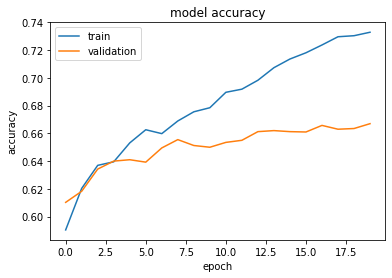

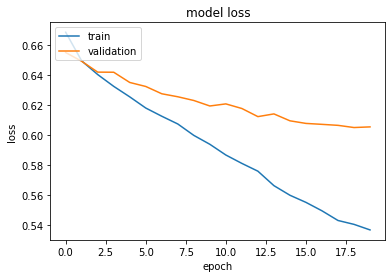

In [ ]:
# list all data in history
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("Evaluation on Unseen Dataset:")

x_test = np.concatenate((samples_unseen, resp_samples_unseen), axis=3)
print(x_test.shape)

model_2.evaluate(x_test, y_unseen)
y_hat = model_2.predict(x_test)

y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_unseen, axis=1)

my_precision = precision_score(y_true, y_pred)
my_recal = recall_score(y_true, y_pred)
my_f1 = f1_score(y_true, y_pred)
print("Precision:", my_precision, "Recall:", my_recal, "f1 score:", my_f1)

Evaluation on Unseen Dataset:
(10000, 32, 32, 6)
313/313 [==============================] - 1s 3ms/step - loss: 0.6163 - accuracy: 0.6593
Precision: 0.673312112581672 Recall: 0.7339298758217677 f1 score: 0.7023154215814766


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[2574, 1950],
       [1457, 4019]])

## With Nearest Neighbor Samples

In [ ]:
train_tuples_NN = pickle.load(open(local_path + "train_tuples_NN.pickle", "rb"))
unseen_tuples_NN = pickle.load(open(local_path + "tuples_unseen_NN.pickle", "rb"))

In [ ]:
# What's inside the tuples: [sample, pos_most_resp_1, prediction, y_truee, y_pred, wx]

In [ ]:
def preprocess_data(train_tuples, unseen_tuples):

  samples = []
  resp_samples = []
  y = []
  y_trues = []
  y_preds = []
  for tpl in train_tuples:
    samples.append(tpl[0])
    resp_samples.append(tpl[1])
    y_trues.append(tpl[3])
    y_preds.append(tpl[4])

    if tpl[2] == 0:
      y.append([1.0,0.0])
    elif tpl[2] == 1:
      y.append([0.0,1.0])

  unseen_samples = []
  unseen_resp_samples = []
  unseen_y = []
  unseen_y_trues = []
  unseen_y_preds = []
  for unseen_tpl in unseen_tuples:
    unseen_samples.append(unseen_tpl[0])
    unseen_resp_samples.append(unseen_tpl[1])
    unseen_y_trues.append(unseen_tpl[3])
    unseen_y_preds.append(unseen_tpl[4])

    if unseen_tpl[2] == 0:
      unseen_y.append([1.0,0.0])
    elif unseen_tpl[2] == 1:
      unseen_y.append([0.0,1.0])

 
  samples = np.array(samples)
  resp_samples = np.array(resp_samples)

  unseen_samples = np.array(unseen_samples)
  unseen_resp_samples = np.array(unseen_resp_samples)

  y = np.array(y)
  unseen_y = np.array(unseen_y)



  print('Training Data:')
  print("Input Shapes:", samples.shape, resp_samples.shape)
  print("Output shape:", y.shape)

  print('Unseen Data:')
  print("Input Image Shapes:", unseen_samples.shape, unseen_resp_samples.shape)
  print("Output shape:", unseen_y.shape)
  return samples, resp_samples, y, y_trues, y_preds, unseen_samples, unseen_resp_samples, unseen_y, unseen_y_trues, unseen_y_preds

In [ ]:
samples, NN_samples, y, y_trues, y_preds, samples_unseen, NN_samples_unseen, y_unseen, y_trues_unseen, y_preds_unseen = preprocess_data(train_tuples_NN, unseen_tuples_NN)

Training Data:
Input Shapes: (20000, 32, 32, 3) (20000, 32, 32, 3)
Output shape: (20000, 2)
Unseen Data:
Input Image Shapes: (10000, 32, 32, 3) (10000, 32, 32, 3)
Output shape: (10000, 2)


In [ ]:
def train_model_2(args): 
  batch_size = args["batch_size"]
  maxepoch = args["maxepoches"]
  num_classes = args["num_classes"]
  model_type = args["model_type"]
  input_shape = args["input_shape"]

  min_lr = args["min_lr"]
  max_lr = args["max_lr"]
  optimizer = args["optimizer"]

  train_samples = args["train_samples"]
  test_samples = args["test_samples"]
  train_resps = args["train_resps"]
  test_resps = args["test_resps"]
  y_train = args["y_train"]
  y_test = args["y_test"]

  model = None

  def lr_scheduler(epoch):
      if epoch <= 0.6 * maxepoch:
        learning_rate = max_lr
      else:
        learning_rate = max_lr + ((epoch + 1 - (0.6 * maxepoch)) * (min_lr - max_lr) / (0.4 * maxepoch) )
      print("Epoch:", epoch, "Learning Rate:", learning_rate)
      return learning_rate

  model = build_model(input_shape, num_classes, model_type)
  reduce_lr = callbacks.LearningRateScheduler(lr_scheduler)
  if optimizer == "sgd":
    opt = optimizers.SGD(learning_rate=min_lr, momentum=0.9, nesterov=True)
  elif optimizer == "adam":
    opt = optimizers.Adam(learning_rate=min_lr)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()

  x_train = np.concatenate((train_samples, train_resps), axis=3)
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    shuffle=True, 
                    epochs=maxepoch,
                    validation_split=0.2,
                    callbacks=[reduce_lr],
                    verbose=1)


  return model, history

In [ ]:
my_args = {"batch_size": 32,
"maxepoches": 20,
"num_classes": y.shape[1],
"model_type": "costum_model2",
"input_shape": [32,32,6],

"min_lr": 0.00001,
"max_lr": 0.0001,
"optimizer": "adam", # different optimizers: adam, sgd


"train_samples": samples, 
"test_samples": samples_unseen,
"train_resps": NN_samples,
"test_resps": NN_samples_unseen,
"y_train": y,
"y_test": y_unseen
}

model_2_NN, hist_NN = train_model_2(my_args)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        1760      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


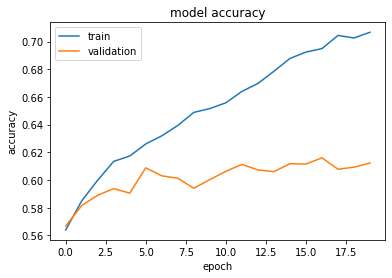

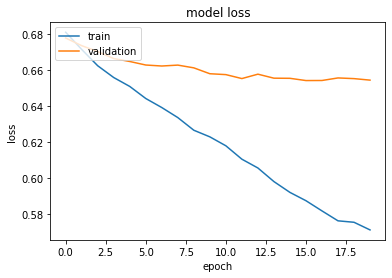

In [ ]:
# list all data in history
print(hist_random.history.keys())
# summarize history for accuracy
plt.plot(hist_NN.history['accuracy'])
plt.plot(hist_NN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_NN.history['loss'])
plt.plot(hist_NN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("Evaluation on Unseen Dataset:")

x_test = np.concatenate((samples_unseen, NN_samples_unseen), axis=3)
print(x_test.shape)

model_2_NN.evaluate(x_test, y_unseen)
y_hat = model_2_NN.predict(x_test)

y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_unseen, axis=1)

my_precision = precision_score(y_true, y_pred)
my_recal = recall_score(y_true, y_pred)
my_f1 = f1_score(y_true, y_pred)
print("Precision:", my_precision, "Recall:", my_recal, "f1 score:", my_f1)

Evaluation on Unseen Dataset:
(10000, 32, 32, 6)
313/313 [==============================] - 1s 3ms/step - loss: 0.6537 - accuracy: 0.6122
Precision: 0.6246489859594384 Recall: 0.7311906501095691 f1 score: 0.673733804475854


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[2118, 2406],
       [1472, 4004]])

## With Just Original Samples

In [ ]:
train_tuples = pickle.load(open(local_path + "train_tuples.pickle", "rb"))
unseen_tuples_random = pickle.load(open(local_path + "tuples_unseen.pickle", "rb"))

In [ ]:
# What's inside the tuples: [sample, pos_most_resp_1, prediction, y_truee, y_pred, wx]

In [ ]:
def preprocess_data(train_tuples, unseen_tuples):

  samples = []
  resp_samples = []
  y = []
  y_trues = []
  y_preds = []
  for tpl in train_tuples:
    samples.append(tpl[0])
    resp_samples.append(tpl[1])
    y_trues.append(tpl[3])
    y_preds.append(tpl[4])

    if tpl[2] == 0:
      y.append([1.0,0.0])
    elif tpl[2] == 1:
      y.append([0.0,1.0])

  unseen_samples = []
  unseen_resp_samples = []
  unseen_y = []
  unseen_y_trues = []
  unseen_y_preds = []
  for unseen_tpl in unseen_tuples:
    unseen_samples.append(unseen_tpl[0])
    unseen_resp_samples.append(unseen_tpl[1])
    unseen_y_trues.append(unseen_tpl[3])
    unseen_y_preds.append(unseen_tpl[4])

    if unseen_tpl[2] == 0:
      unseen_y.append([1.0,0.0])
    elif unseen_tpl[2] == 1:
      unseen_y.append([0.0,1.0])

 
  samples = np.array(samples)
  resp_samples = np.array(resp_samples)

  unseen_samples = np.array(unseen_samples)
  unseen_resp_samples = np.array(unseen_resp_samples)

  y = np.array(y)
  unseen_y = np.array(unseen_y)



  print('Training Data:')
  print("Input Shapes:", samples.shape, resp_samples.shape)
  print("Output shape:", y.shape)

  print('Unseen Data:')
  print("Input Image Shapes:", unseen_samples.shape, unseen_resp_samples.shape)
  print("Output shape:", unseen_y.shape)
  return samples, resp_samples, y, y_trues, y_preds, unseen_samples, unseen_resp_samples, unseen_y, unseen_y_trues, unseen_y_preds

In [ ]:
samples, resp_samples, y, y_trues, y_preds, samples_unseen, resp_samples_unseen, y_unseen, y_trues_unseen, y_preds_unseen = preprocess_data(train_tuples, unseen_tuples)

Training Data:
Input Shapes: (20000, 32, 32, 3) (20000, 32, 32, 3)
Output shape: (20000, 2)
Unseen Data:
Input Image Shapes: (10000, 32, 32, 3) (10000, 32, 32, 3)
Output shape: (10000, 2)


In [ ]:
def train_model_2(args): 
  batch_size = args["batch_size"]
  maxepoch = args["maxepoches"]
  num_classes = args["num_classes"]
  model_type = args["model_type"]
  input_shape = args["input_shape"]

  min_lr = args["min_lr"]
  max_lr = args["max_lr"]
  optimizer = args["optimizer"]

  train_samples = args["train_samples"]
  test_samples = args["test_samples"]
  train_resps = args["train_resps"]
  test_resps = args["test_resps"]
  y_train = args["y_train"]
  y_test = args["y_test"]

  model = None

  def lr_scheduler(epoch):
      if epoch <= 0.6 * maxepoch:
        learning_rate = max_lr
      else:
        learning_rate = max_lr + ((epoch + 1 - (0.6 * maxepoch)) * (min_lr - max_lr) / (0.4 * maxepoch) )
      print("Epoch:", epoch, "Learning Rate:", learning_rate)
      return learning_rate

  model = build_model(input_shape, num_classes, model_type)
  reduce_lr = callbacks.LearningRateScheduler(lr_scheduler)
  if optimizer == "sgd":
    opt = optimizers.SGD(learning_rate=min_lr, momentum=0.9, nesterov=True)
  elif optimizer == "adam":
    opt = optimizers.Adam(learning_rate=min_lr)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()

  x_train = train_samples 
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    # steps_per_epoch=samples.shape[0] // batch_size,
                    shuffle=True, 
                    epochs=maxepoch,
                    validation_split=0.2,
                    callbacks=[reduce_lr],
                    verbose=1)

  return model, history

In [ ]:
my_args = {"batch_size": 32,
"maxepoches": 20,
"num_classes": y.shape[1],
"model_type": "costum_model2",
"input_shape": [32,32,3],

"min_lr": 0.00001,
"max_lr": 0.0001,
"optimizer": "adam", # different optimizers: adam, sgd


"train_samples": samples, 
"test_samples": samples_unseen,
"train_resps": samples,
"test_resps": samples_unseen,
"y_train": y,
"y_test": y_unseen
}

model_2_original, hist_original = train_model_2(my_args)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


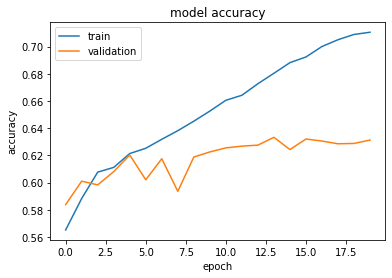

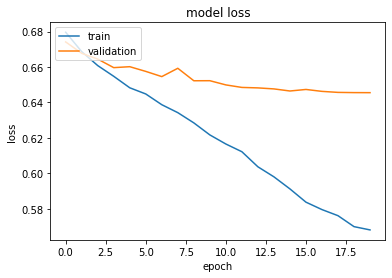

In [ ]:
# list all data in history
print(hist_original.history.keys())
# summarize history for accuracy
plt.plot(hist_original.history['accuracy'])
plt.plot(hist_original.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_original.history['loss'])
plt.plot(hist_original.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("Evaluation on Unseen Dataset:")

# x_test = np.concatenate((samples_unseen, random_samples_unseen), axis=3)
x_test = samples_unseen
print(x_test.shape)

model_2_original.evaluate(x_test, y_unseen)
y_hat = model_2_original.predict(x_test)

y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_unseen, axis=1)

my_precision = precision_score(y_true, y_pred)
my_recal = recall_score(y_true, y_pred)
my_f1 = f1_score(y_true, y_pred)
print("Precision:", my_precision, "Recall:", my_recal, "f1 score:", my_f1)

Evaluation on Unseen Dataset:
(10000, 32, 32, 3)
313/313 [==============================] - 1s 2ms/step - loss: 0.6532 - accuracy: 0.6183
Precision: 0.6378135902973916 Recall: 0.7010591672753835 f1 score: 0.6679425837320575


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[2344, 2180],
       [1637, 3839]])